In [ ]:
!wget https://storage.yandexcloud.net/medium/database.json
!wget https://upload.wikimedia.org/wikipedia/commons/f/fb/K6ka_self-portrait_with_D7100_2021-08-17.jpg -O tmp.jpg

In [3]:
with open('database.json') as f:
    data = f.read()
dataset = json.loads(data)

In [ ]:
dataset[0]

In [5]:
import torch
import json
import numpy as np
from PIL import Image
from scipy import spatial
from random import randint
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from urllib.request import urlopen
from torchvision import transforms, models, datasets

# We open the json file and put everything in it into the variable 'dataset'
with open('database.json') as f:
    data = f.read()
dataset = json.loads(data)

# we cut last 30 nums, because this demo uses only backbone features extraction part
embeddings = [tmp['embedding'][:-30] for tmp in dataset]
urls = [tmp['url'] for tmp in dataset] # extract 'url' for each element in dataset

# create search tree
tree = spatial.KDTree(embeddings)

# define preprocessing transforms
prepare = transforms.Compose([transforms.PILToTensor(),
                                 transforms.CenterCrop(10),
                                 transforms.Resize(224)])
norm = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

# The function prepare image takes in the images and makes them into a form that the program can use
def prepare_image(img_path):
  img = Image.open(img_path).convert('RGB')
  img = prepare(img).unsqueeze(0)/255
  img = norm(img)
  embedded = emb(img.to(device))
  return embedded.detach().flatten().cpu().numpy()

# embedder class with feature extractor from network
class Embedder(torch.nn.Module):

    def __init__(self, net):
        super(Embedder, self).__init__()
        self.backbone = net
        # we use here universal syntax, because diff archs can have diff names for feature extraction part
        self.feature_extractor = torch.nn.Sequential(*(list(net.children())[:-1]))

    def forward(self, x):
        features = self.feature_extractor(x)[0].flatten()
        return features.flatten()

In [ ]:
# TODO
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# define backbone model and embedder class
net = models.regnet_y_400mf(pretrained=True)
emb = Embedder(net).to(device)
emb.eval()

In [8]:
def show_images(img_path):
  '''
    search urls for 3 nearest pictures in search tree,
    opens it with urlopen and shows in 1 row

    img_path - path to input image
  '''
  fig = plt.figure(figsize=(10, 7))
  rows = 1
  columns = 4

  input_embedding = prepare_image(img_path)
  idx = tree.query(input_embedding,3)

  fig.add_subplot(rows, columns, 1)
  plt.imshow(Image.open(img_path))
  plt.axis('off')

  fig.add_subplot(rows, columns, 2)
  plt.imshow(Image.open(urlopen(urls[idx[1][0]])))
  plt.axis('off')

  fig.add_subplot(rows, columns, 3)
  plt.imshow(Image.open(urlopen(urls[idx[1][1]])))
  plt.axis('off')

  fig.add_subplot(rows, columns, 4)
  plt.imshow(Image.open(urlopen(urls[idx[1][2]])))
  plt.axis('off')


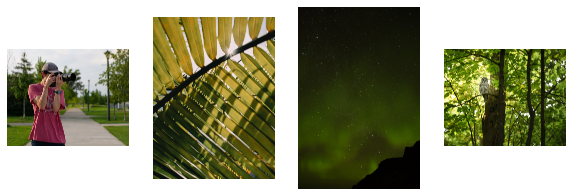

In [11]:
show_images('tmp.jpg')